In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys
import torch
from   torch.utils import data

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data.data_utils import Dataset

/home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Compare LV results

### load data

In [2]:
data_path_test = '../data/lv/lv-te-data-clean.pkl'
data_path_train = '../data/lv/lv-tr-data-clean.pkl'
device = 'cpu'
dtype = torch.float64
batch_size = 20
shuffle = True
num_workers = 0
Ntrain = 500

In [3]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)
X_tr = torch.load(data_path_train)
X_tr = X_tr.to(device).to(dtype)

In [4]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(X_tr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [3]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive

In [7]:
T_in = 8
T_inv = 40
ode_latent_dim = 8
inv_latent_dim = 8
order = 1 
D_in  = ode_latent_dim + inv_latent_dim
D_out = int(ode_latent_dim / order)
solver = 'euler'
use_adjoint = False
frames = 5
dt = 0.1
aug = True
Nobj = 1
task ='lv'
n_filt = 8 
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'dcgan'
last_layer_gp  = None

In [8]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [9]:
node_inv_contr.to(device)
fname = '../results/lv/21_01_2023-20:33/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../results/lv/21_01_2023-20:33/invodevae.pth'

##### Node + inv 

In [9]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [10]:
node_inv.to(device)
fname = '../results/lv/21_01_2023-21:17/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=16, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=8, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=16, bias=True)
        )
        (gru): GRU(2, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=100, bias=True)
      

##### Node 

In [11]:
T_in = 40
inv_latent_dim=0
D_in = ode_latent_dim
D_out = int(D_in/order)
aug=False
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [12]:
node_base.to(device)
fname = '../results/lv/21_01_2023-21:18/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=8, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=16, bias=True)
        )
        (gru): GRU(2, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=100, bias=True)
       

### plot results

In [13]:
X_te_idx = [4,10,3,15,18,20]#[0,2,3,4,7,10] #1,3,4
#subset for only 2 lines
#X_te_idx = [2,7,0,18] #for report 

##### Phase Diagram

In [14]:
from matplotlib import cm
from numpy import linspace

def plot_latent_traj(Q, Nplot=10, show=False, fname='latents.png'): #TODO adjust for 2nd ordder (dont think it is right atm)
    [L,N,T,q] = Q.shape 
    cm_subsection = linspace(0.0, 1.0, N) 
    colors = [ cm.tab20c(x) for x in cm_subsection ]
    if q>2:
        Q = Q.reshape(L*N*T,q)
        U,S,V = torch.pca_lowrank(Q, q=min(q,10))
        Qpca = Q @ V[:,:2] 
        Qpca = Qpca.reshape(L,N,T,2).detach().cpu().numpy() # L,N,T,2
        S = S / S.sum()
    else:
        Qpca = Q.detach().cpu().numpy()
    Qpca_mean = np.mean(Qpca, axis=0)
    plt.figure(1,(5,5))
    for n in range(Nplot):
        for l in range(L):
            plt.plot(Qpca[l,n,:,0], Qpca[l,n,:,1], '--', lw=0.4, color=colors[n], alpha=0.5)
            # plt.plot(Qpca[l,n,0,0], Qpca[l,n,0,1], '*', markersize=15, color=colors[n])
        plt.plot(Qpca_mean[n,:,0], Qpca_mean[n,:,1], '-', lw=0.8, color=colors[n], alpha=1)
        plt.plot(Qpca_mean[n,0,0], Qpca_mean[n,0,1], '*', markersize=15, color=colors[n])
    if q>2:
        plt.xlabel('PCA-1  ({:.2f})'.format(S[0]),fontsize=15)
        plt.ylabel('PCA-2  ({:.2f})'.format(S[1]),fontsize=15)
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

from matplotlib.legend_handler import HandlerLine2D
def plot_1d(X, Xrec, show=False, fname='predictions.png',D=None, N=None, dim=0, C=2, L=None, ymax=200, T_in = 3, T_inv=10, T=50, data_name='Prey', model_name='model', color_line_prey='seagreen', color_line_predator='purple', trajctory_idx=None):
    ''' 
        For spiral and lv dataset (d=2)
        X    - [N,T,d] 
        Xrec - [L,N,Ttest,d]
    '''
    if N is None:
        N = min(X.shape[0],3)
    if D is None:
        D = min(X.shape[-1],3)
    Xnp    = X.detach().cpu().numpy()
    Xrecnp = Xrec.detach().cpu().numpy()
    Xrecnp_mean = np.mean(Xrecnp, axis=0)
    T = Xnp.shape[1]
    nc,nr = 1, N
    fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False,sharex=True) #, sharey=True)
    nidx = 0
    d=0
    for n in range(N):
        axes[n,d].text(0.075, 0.95, 'Trajectory id: {}'.format(trajctory_idx[n]),fontsize=12, bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='center', verticalalignment='top', transform=axes[n,d].transAxes)
        axes[n,d].axvline(x=T_in,linewidth=2, color='grey', ls='-')
        if T_inv is not None:
            axes[n,d].axvline(x=T_inv,linewidth=2, color='grey', ls='-.')
        axes[n,d].axvline(x=T,linewidth=2, color='grey', ls=':')
        for dim in range(D):
            if n==0 and dim==0:
                axes[n,d].plot(Xrecnp_mean[n,:,dim].T, '-', color=color_line_prey, lw=1.0, alpha=1, label='Prey '+model_name)
                axes[n,d].plot(Xnp[n,:,dim].T, '-', color='black', lw=1.0)
            elif n==0 and dim==1:
                axes[n,d].plot(Xrecnp_mean[n,:,dim].T, '-', color=color_line_predator, lw=1.0, alpha=1, label='Predator '+model_name)
                axes[n,d].plot(Xnp[n,:,dim].T, '-', color='black', lw=1.0,label='Target')
                leg = axes[n,d].legend(ncol=3, prop={'size': 14}, loc='upper center', bbox_to_anchor=(0.5, 1.4))
                # set the linewidth of each legend object
                for legobj in leg.legendHandles:
                    legobj.set_linewidth(4.0)
            elif dim==0:
                axes[n,d].plot(Xrecnp_mean[n,:,dim].T, '-', color=color_line_prey, lw=1.0, alpha=1)
                axes[n,d].plot(Xrecnp[:,n,:,dim].T, '--', color=color_line_prey, lw=0.5, alpha=0.3)
                axes[n,d].plot(Xnp[n,:,dim].T, '-', color='black', lw=1.0)
            elif dim==1:
                axes[n,d].plot(Xrecnp_mean[n,:,dim].T, '-', color=color_line_predator, lw=1.0, alpha=1)
                axes[n,d].plot(Xrecnp[:,n,:,dim].T, '--', color=color_line_predator, lw=0.5, alpha=0.3)
                axes[n,d].plot(Xnp[n,:,dim].T, '-', color='black', lw=1.0)
            
            axes[n,d].set_xlim([-1, ymax])
        
    
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close() 


def plot_2d(X, Xrec, Xrec_inv, Xrec_base, show=False, fname='predictions.png', color_cont ='seagreen', color_inv ='mediumpurple', color_base='royalblue', trajectory_idx=None, xcord=0.0, ycord=0.0):
    ''' 
        For spiral and lv dataset (d=2)
        X    - [T,d] 
        Xrec - [L,Ttest,d]
    '''    
    [L,T,q] = Xrec.shape 
    Xnp    = X.detach().cpu().numpy()

    Xrecnp = Xrec.detach().cpu().numpy()
    Xrecnp_inv = Xrec_inv.detach().cpu().numpy()
    Xrecnp_base = Xrec_base.detach().cpu().numpy()

    Xrecnp_mean = np.mean(Xrecnp, axis=0) #T, d
    Xrecnp_inv_mean = np.mean(Xrecnp_inv, axis=0) #T, do
    Xrecnp_base_mean = np.mean(Xrecnp_base, axis=0) #T, do

    
    plt.figure(1,figsize=(6, 6))

    plt.text(xcord, ycord, 'Trajectory id: {}'.format(trajectory_idx),fontsize=12, bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='center', verticalalignment='top')
    plt.plot(Xrecnp_base_mean[:,0], Xrecnp_base_mean[:,1], '-', lw=2, color=color_base, alpha=1, label='NODE')
    plt.plot(Xrecnp_inv_mean[:,0], Xrecnp_inv_mean[:,1], '-', lw=2, color=color_inv, alpha=1, label='INODE')
    plt.plot(Xrecnp_mean[:,0], Xrecnp_mean[:,1], '-', lw=2, color=color_cont, alpha=1, label='SINODE')
    
    
    for l in range(L):
        plt.plot(Xrecnp[l,:,0],Xrecnp[l,:,1], '--', lw=0.5, color=color_cont, alpha=0.6)
        plt.plot(Xrecnp_inv[l,:,0],Xrecnp_inv[l,:,1], '--', lw=0.5, color=color_inv, alpha=0.6)
        plt.plot(Xrecnp_base[l,:,0],Xrecnp_base[l,:,1], '--', lw=0.5, color=color_base, alpha=0.6)

    plt.plot(Xnp[:,0], Xnp[:,1], '-', color='black', lw=1.2, label='Target')

    leg = plt.legend(ncol=1, prop={'size': 14}, bbox_to_anchor=(0.7, 0.7)) #loc='upper right'
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
   # plt.legend(loc='upper right')
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

In [43]:
plotL=20
forecast_te = 3

##### Node+ inv +cont

In [73]:
Xrec_te_contr, ztL_te_contr, _, _, C_contr = node_inv_contr(X_te[X_te_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

Rollout plots

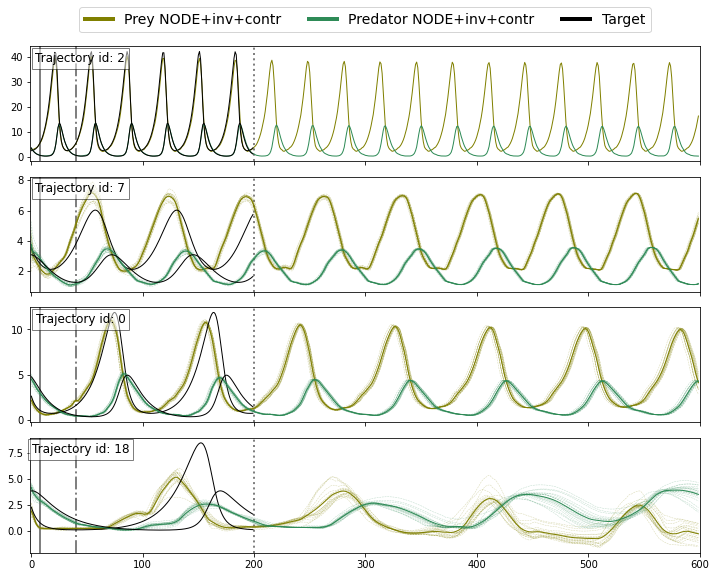

In [45]:
plot_1d(X_te[X_te_idx], Xrec_te_contr,show=True,N=4, ymax=600, model_name='NODE+inv+contr', \
    T_in=8, T_inv=40, T=200,color_line_predator='seagreen',color_line_prey='olive', trajctory_idx=X_te_idx)

IndexError: index 4 is out of bounds for axis 1 with size 4

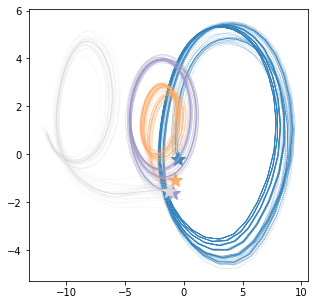

In [46]:
plot_latent_traj(ztL_te_contr[:,:,:200], show=True, Nplot=6)

##### Node+ inv

In [74]:
Xrec_te_inv, ztL_te_inv, _, _, C_inv = node_inv(X_te[X_te_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

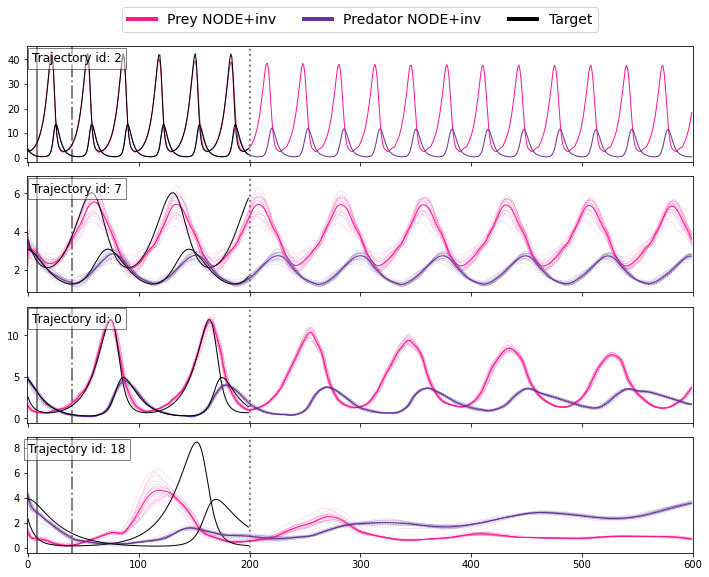

In [ ]:
plot_1d(X_te[X_te_idx], Xrec_te_inv,show=True,N=4, ymax=600, model_name='NODE+inv',\
    T_in=8, T_inv=40, T=200, color_line_predator='rebeccapurple',color_line_prey='deeppink',trajctory_idx=X_te_idx)

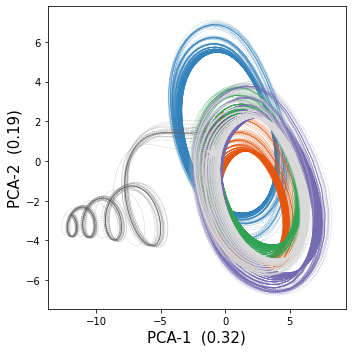

In [ ]:
plot_latent_traj(ztL_te_inv, show=True, Nplot=6)

##### Node 

In [75]:
Xrec_te_base, ztL_te_base, _, _, C_base = node_base(X_te[X_te_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

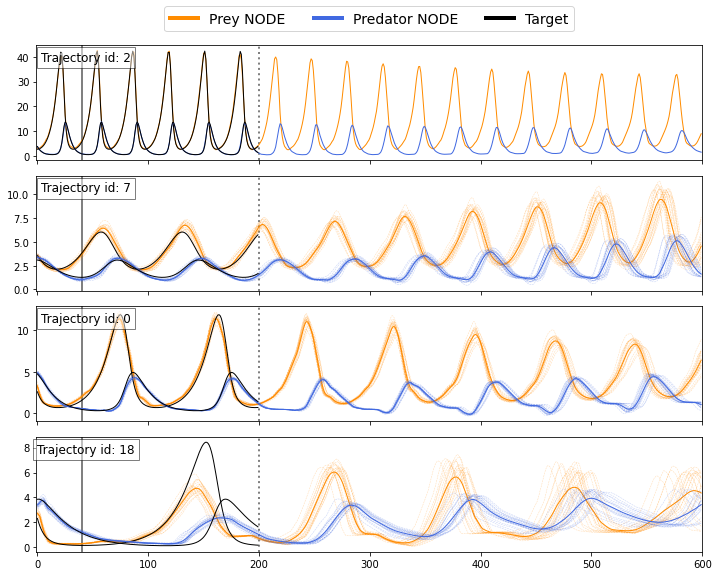

In [110]:
plot_1d(X_te[X_te_idx], Xrec_te_base,show=True,N=4, ymax=600, model_name='NODE',\
    T_in=40, T_inv=None, T=200, color_line_predator='royalblue',color_line_prey='darkorange',trajctory_idx=X_te_idx)

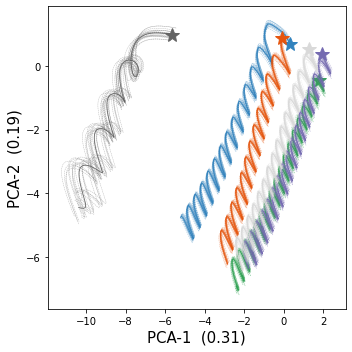

In [63]:
plot_latent_traj(ztL_te_base, show=True, Nplot=6)

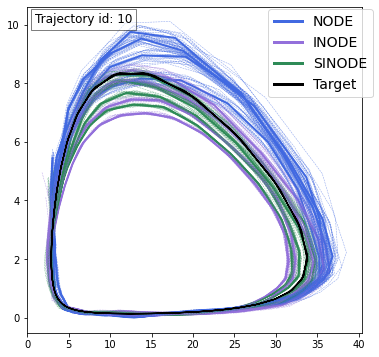

In [87]:
#select if from 0-2
idx =1
T= 200
plot_2d(X_te[X_te_idx[idx],:200], Xrec_te_contr[:,idx,:T], Xrec_te_inv[:,idx,:T], Xrec_te_base[:,idx,:T], \
    show=True, trajectory_idx = X_te_idx[idx], xcord=6.8, ycord=10.4)

Compute MSE 

Need to generate sequences of length 600 for comparison 

In [12]:
from data.data_gen import gen_lv_data

In [89]:
gen_lv_data('../data/lv/long_seq.pkl', N=100, T=600, clean='clean')

In [15]:
X_long = torch.load('../data/lv/long_seq.pkl')
X_long = X_long.to(device).to(dtype)

In [16]:
from model.misc.plot_utils import plot_2d_origin

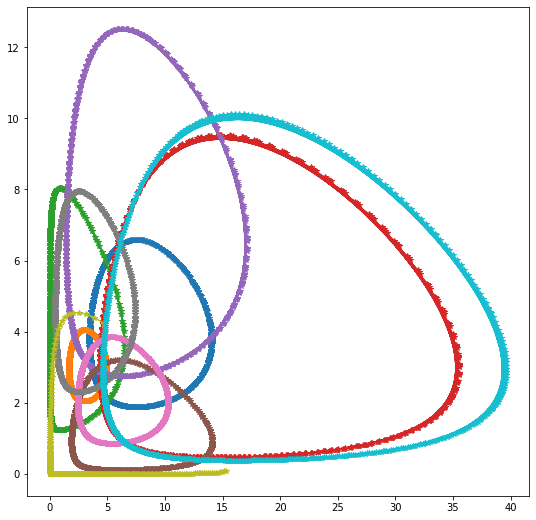

In [98]:
plot_2d_origin(X_long,show=True)

In [17]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers, 'drop_last': True}
longset = Dataset(X_long)
longset = data.DataLoader(longset, **params)

In [115]:
# def compute_mse(model, dataset, T_inv=40, T=200, T_forecast=600, L=20): 
#   #  T_set = [T_inv, T, T_forecast]
#     T_set = [T_inv, T] #, T_forecast]
#     dict_mse = {str(T):(None,None) for T in T_set}
#     for T in T_set:
#         mses=[]
#         print('T', T)
#         #for ep in range(Eps): #check one more time
#         for data_batch in dataset:
#             data_batch = data_batch.to(model.device) #N,T,dim
#             [N_,T_,d] = data_batch.shape
#             if T_ != T:
#                 # t0s = torch.randint(0,T_-T,[N_])
#                 # in_data= torch.stack([data_batch[n,t0:t0+T] for n,t0 in enumerate(t0s)])
#                 in_data = data_batch[:,:T]
#             else:
#                 in_data = data_batch
#             #in_data = data_batch[:,:T] #use different subsequences 
#            # print('in_data', in_data.shape)
#             print('max in data', in_data.reshape(-1,2).max(axis=0))
#             Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
#            # print('Xrec', Xrec.shape)
#             print('max Xrec-in_data', (Xrec-in_data).mean(0).reshape(-1,2).max(axis=0))
#             mse   = torch.mean((Xrec-in_data)**2) 
            
#             if mse>5.0:
#                 plot_2d_origin(Xrec.mean(0)-in_data,show=True)
#                 # plot_2d_origin(in_data,show=True)
#                 # plot_2d_origin(Xrec.mean(0),show=True)
#             mses.append(mse.item())
        
#         dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
#     return dict_mse

In [18]:
def compute_mse(model, dataset, T_inv=40, T=200, T_forecast=600, L=20): 
    T_set = [T_inv, T, T_forecast]
    dict_mse = {str(T):(None,None) for T in T_set}
    for T in T_set:
        mses=[]
        for data_batch in dataset:
            data_batch = data_batch.to(model.device) #N,T,dim
            [N_,T_,d] = data_batch.shape
            if T_ != T:
                in_data = data_batch[:,:T]
            else:
                in_data = data_batch
            Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
            mse   = torch.mean((Xrec-in_data)**2) 
            mses.append(mse.item())
        
        dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
    return dict_mse

Neural-ODE + inv + contr

In [19]:
node_inv_contr_mse = compute_mse(node_inv_contr, longset)
for key,item in node_inv_contr_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 40 with mse 0.753 (0.236)
Sequence length 200 with mse 2.742 (1.647)
Sequence length 600 with mse 10.580 (3.233)


Neural-ODE + inv

In [20]:
node_inv_mse = compute_mse(node_inv, longset)
for key,item in node_inv_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 40 with mse 0.698 (0.181)
Sequence length 200 with mse 2.640 (1.010)
Sequence length 600 with mse 14.875 (5.614)


Neural-ODE

In [21]:
node_base_mse = compute_mse(node_base, longset)
for key,item in node_base_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 40 with mse 0.416 (0.101)
Sequence length 200 with mse 2.941 (0.691)
Sequence length 600 with mse 23.735 (3.210)


plot report

In [22]:
def plot_mse(model_inv_contr, model_inv, model_base):
    fig = plt.figure(figsize=(4,4))
    x = [1,2,3]

    plt.errorbar(x, [item[0] for key, item in model_base.items()], yerr=[item[1] for key, item in model_base.items()], ls='-.', marker="s", color="royalblue", label='NODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv.items()], yerr=[item[1] for key, item in model_inv.items()], ls=':', marker="v", color="darkviolet", label='INODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv_contr.items()], yerr=[item[1] for key, item in model_inv_contr.items()], ls='--', marker="o", color="seagreen", label='SINODE', capsize=5)

    plt.xticks(x, [key for key, item in model_inv_contr.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    #plt.ylabel('MSE', fontdict={"size":12})
    plt.xlabel('Prediction Horizon', fontdict={"size":16})
    plt.grid()
    plt.show()
    

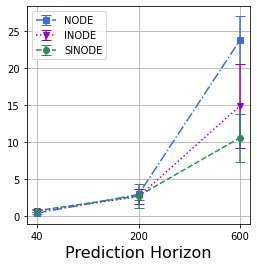

In [23]:
plot_mse(node_inv_contr_mse, node_inv_mse, node_base_mse)

Invariance Matrix

In [30]:
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()

Contrastive Matrix Z

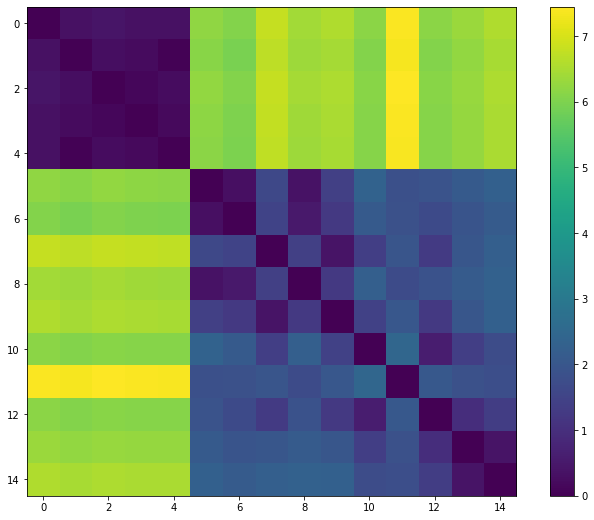

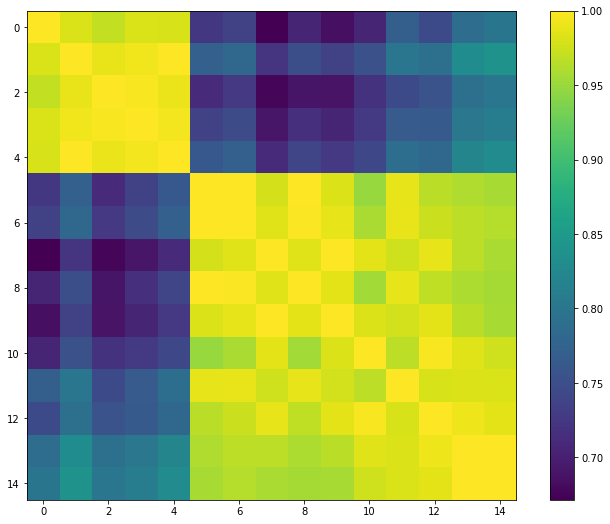

In [35]:
plot_C(C_contr)

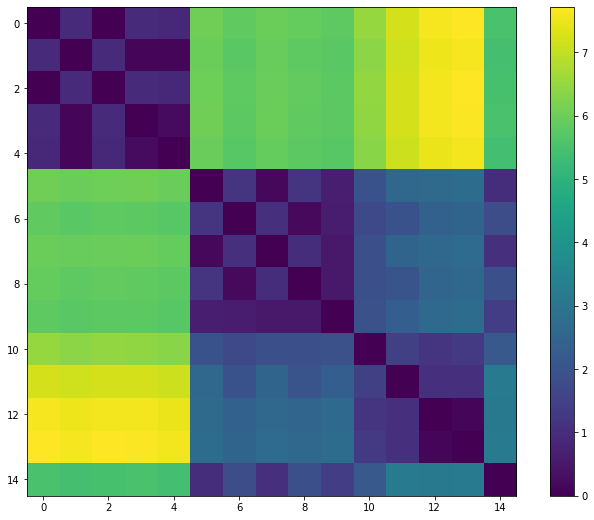

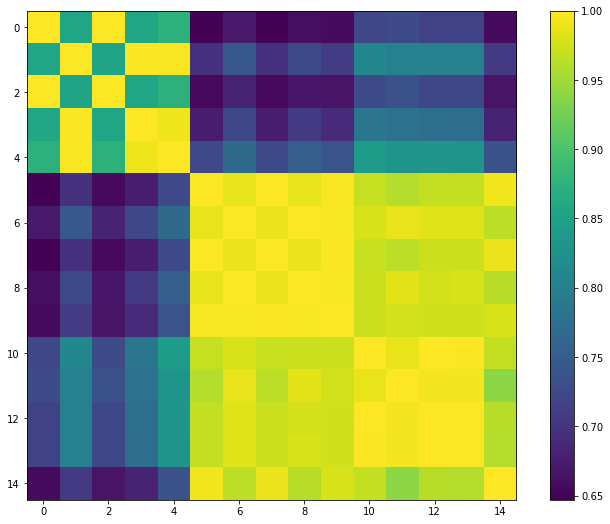

In [37]:
plot_C(C_inv)